# What makes a competent software engineer?

Introduction goes here

In [45]:
# imports
import pandas as pd
import numpy
from scipy import stats
from IPython.display import display

In [3]:
# grab all the data we need from the db
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/rachel/projects/eng_survey_raw/results.db')
with engine.connect() as conn, conn.begin():
    eng_traits_data = pd.read_sql_table('q1_competent_software_engineer_traits', conn)
    education_data = pd.read_sql_table('q21q24_education', conn)
    setup_questions_data = pd.read_sql_table('q3q6_setup_questions', conn)

In [4]:
# plots n graphs setup shenanigans
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 20)
plt.rcParams['font.family'] = 'sans-serif'

In [5]:
# constants
HAS_CS_DEGREE = "Yes, computer science" # answer to "Do you have a CS or SWE degree?"
HAS_SWE_DEGREE = "Yes, software engineering (BSE, etc)" # answer to "Do you have a CS or SWE degree?"
DOES_NOT_HAVE_CS_DEGREE = "No" # answer to "Do you have a CS or SWE degree?"

# Do engineers with CS degrees value different skills than engineers without CS degrees? 

An interesting way to slice this data is by people who have CS degrees vs. people who do not. 


In [6]:
# this gets a list of engineering traits so we can pivot on them later
excluded_trait_columns = ('id', 'response_id', 'something_else_writein1', 'something_else_writein2')
eng_traits = [trait for trait in list(eng_traits_data.columns.values) if trait not in excluded_trait_columns]

In [7]:
# Smoosh the right bits of data together. In this case, we want 1) eng traits 
# 2) split out by CS degree 3) by people who identify themselves as engineers 

edu_traits_data = pd.merge(eng_traits_data, 
                           education_data[["response_id", "have_cs_degree"]][education_data.have_cs_degree != ""], 
                           on="response_id", 
                           how="inner",
                           sort=False)
only_software_engineers = setup_questions_data.query("are_you_a_software_engineer == True")

edu_traits_engineers_only_data = pd.merge(edu_traits_data, only_software_engineers[["response_id"]], on="response_id", how="inner", sort=False)

In [8]:
traits_data = pd.pivot_table(edu_traits_engineers_only_data, index=["have_cs_degree"], values=eng_traits)

# How many traits did people pick? 

The first raw measurement

In [9]:
edu_traits_engineers_only_data['number_selected'] = edu_traits_engineers_only_data[eng_traits].sum(axis=1, numeric_only=True)

In [10]:
number_selected = edu_traits_engineers_only_data['number_selected']

selected_std_dev = numpy.std(number_selected)
selected_mean = numpy.mean(number_selected)
selected_std_dev, selected_mean

(6.41488239632902, 20.706870229007635)

In [46]:
traits_count_by_degree = pd.pivot_table(edu_traits_engineers_only_data, 
                                        index=["have_cs_degree"], 
                                        values=['number_selected'],
                                        aggfunc=[numpy.mean, numpy.std])
traits_count_by_degree

,mean,std
,number_selected,number_selected
have_cs_degree,,
No,20.297872,5.945475
"Yes, computer science",21.180602,6.556478
"Yes, software engineering (BSE, etc)",20.351351,7.482276


## What does each group value the highest?

If you sort by the top 10 traits valued by both groups, 9 out of 10 are the same, with the top 5 being exactly the same and in the same order. 

Interestingly, there's only one true technical skill on both lists, and it's the 1 out of 10 that disagreed: engineers with CS degrees value rated data structures higher and engineers without rated knowing language features higher.

All the other skills are primarily social, e.g. teamwork, empathy, curiousity, humility, or technically social:  being fluent in both reading other people's code and writing for them as well as making tradeoffs.

In [12]:
traits_data.stack()[HAS_CS_DEGREE].sort_values(ascending=False)[:10]

logically_work_through_problem     0.943144
write_code_for_others              0.939799
reason_about_other_peoples_code    0.916388
can_admit_mistakes                 0.869565
teamwork                           0.856187
shipping_code                      0.819398
data_structures                    0.792642
empathy                            0.789298
curiousity                         0.782609
can_make_tradeoffs                 0.772575
dtype: float64

In [13]:
traits_data.stack()[DOES_NOT_HAVE_CS_DEGREE].sort_values(ascending=False)[:10]

logically_work_through_problem     0.939716
write_code_for_others              0.925532
reason_about_other_peoples_code    0.904255
can_admit_mistakes                 0.886525
teamwork                           0.861702
curiousity                         0.836879
can_make_tradeoffs                 0.819149
empathy                            0.815603
shipping_code                      0.783688
language_features_knowledge        0.726950
dtype: float64

## What do people with CS and non-CS degrees value differently?

The next interesting question is: are there traits each group values more than the other? 

TODO: should we change this to be by raw numbers instead of comparing percentages? idk

In [14]:
traits_by_degree = traits_data.transpose().filter([HAS_CS_DEGREE, DOES_NOT_HAVE_CS_DEGREE])
traits_by_degree['Difference'] = (traits_by_degree[HAS_CS_DEGREE] - traits_by_degree[DOES_NOT_HAVE_CS_DEGREE])
traits_by_degree.applymap(lambda x: '%.1f%%' % (x * 100))

have_cs_degree,"Yes, computer science",No,Difference
adapability,60.2%,62.4%,-2.2%
advanced_algorithms,18.1%,11.7%,6.4%
can_act_in_crisis,36.5%,35.8%,0.6%
can_admit_mistakes,87.0%,88.7%,-1.7%
can_handle_disruptions_or_interruptions,26.4%,29.1%,-2.7%
can_learn_quickly,63.9%,67.0%,-3.1%
can_make_tradeoffs,77.3%,81.9%,-4.7%
code_structure_skills,70.9%,70.9%,-0.0%
concurrency,65.2%,50.0%,15.2%
curiousity,78.3%,83.7%,-5.4%


In [15]:
traits_difference = traits_by_degree.apply(lambda row: (row[HAS_CS_DEGREE] - row[DOES_NOT_HAVE_CS_DEGREE]) * 100,axis=1)


(6.689240133794612, 2.2634094006754646)

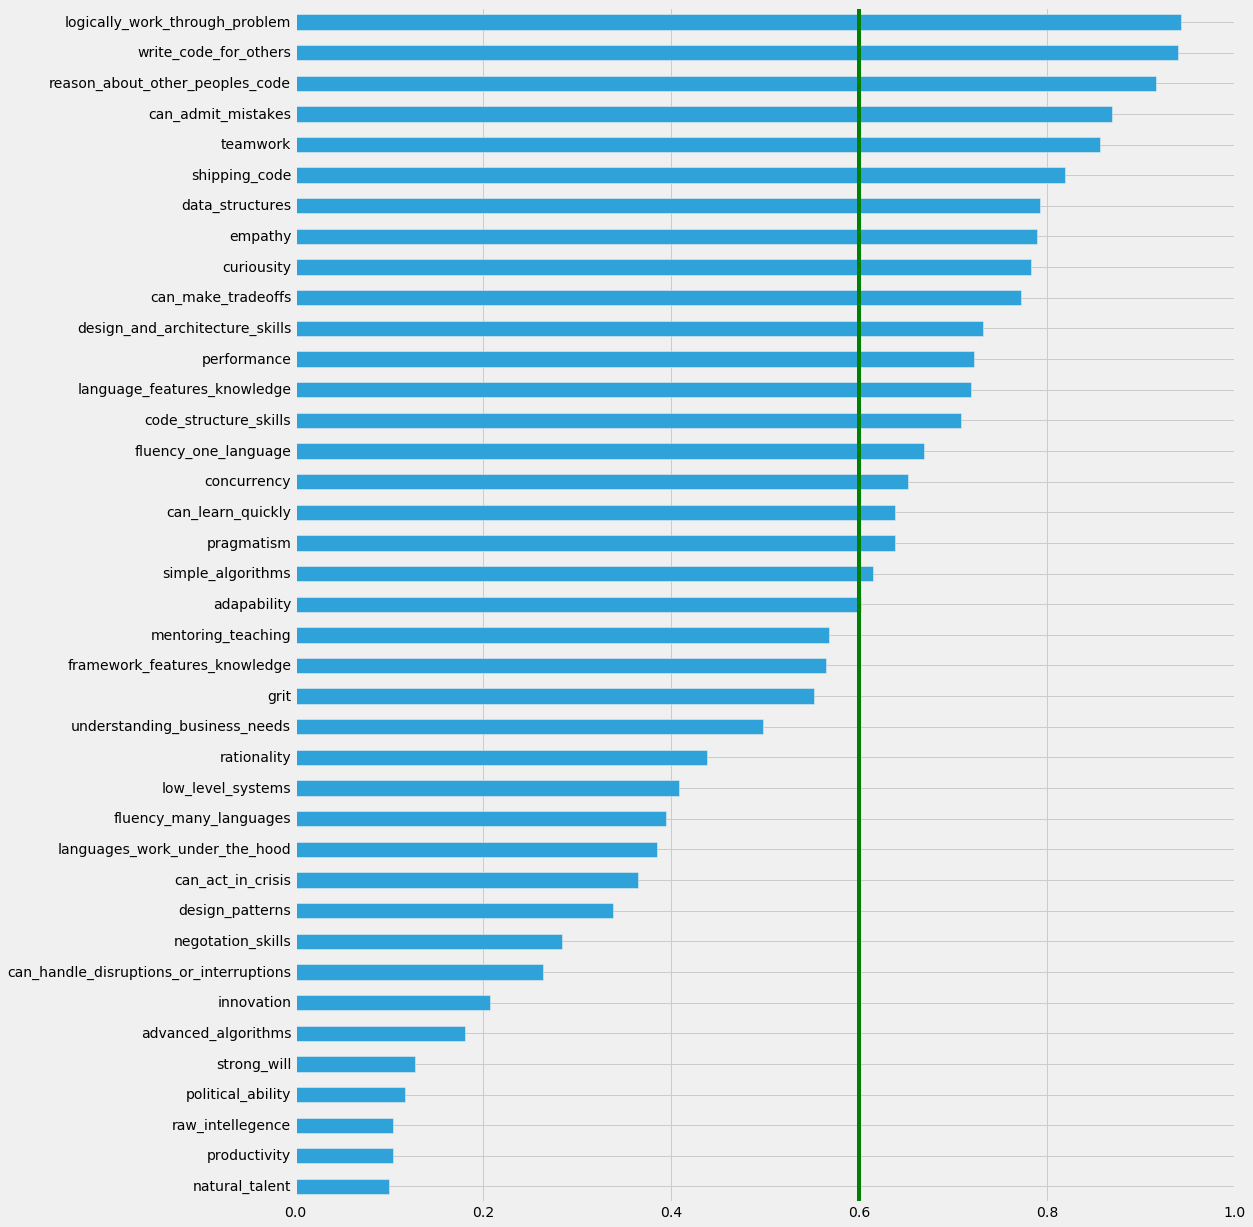

In [16]:
trait_plot2 = traits_data.stack()[HAS_CS_DEGREE].sort_values(ascending=True).plot(kind='barh')
trait_plot2.axvline(0.6, color='g')

plt.show()

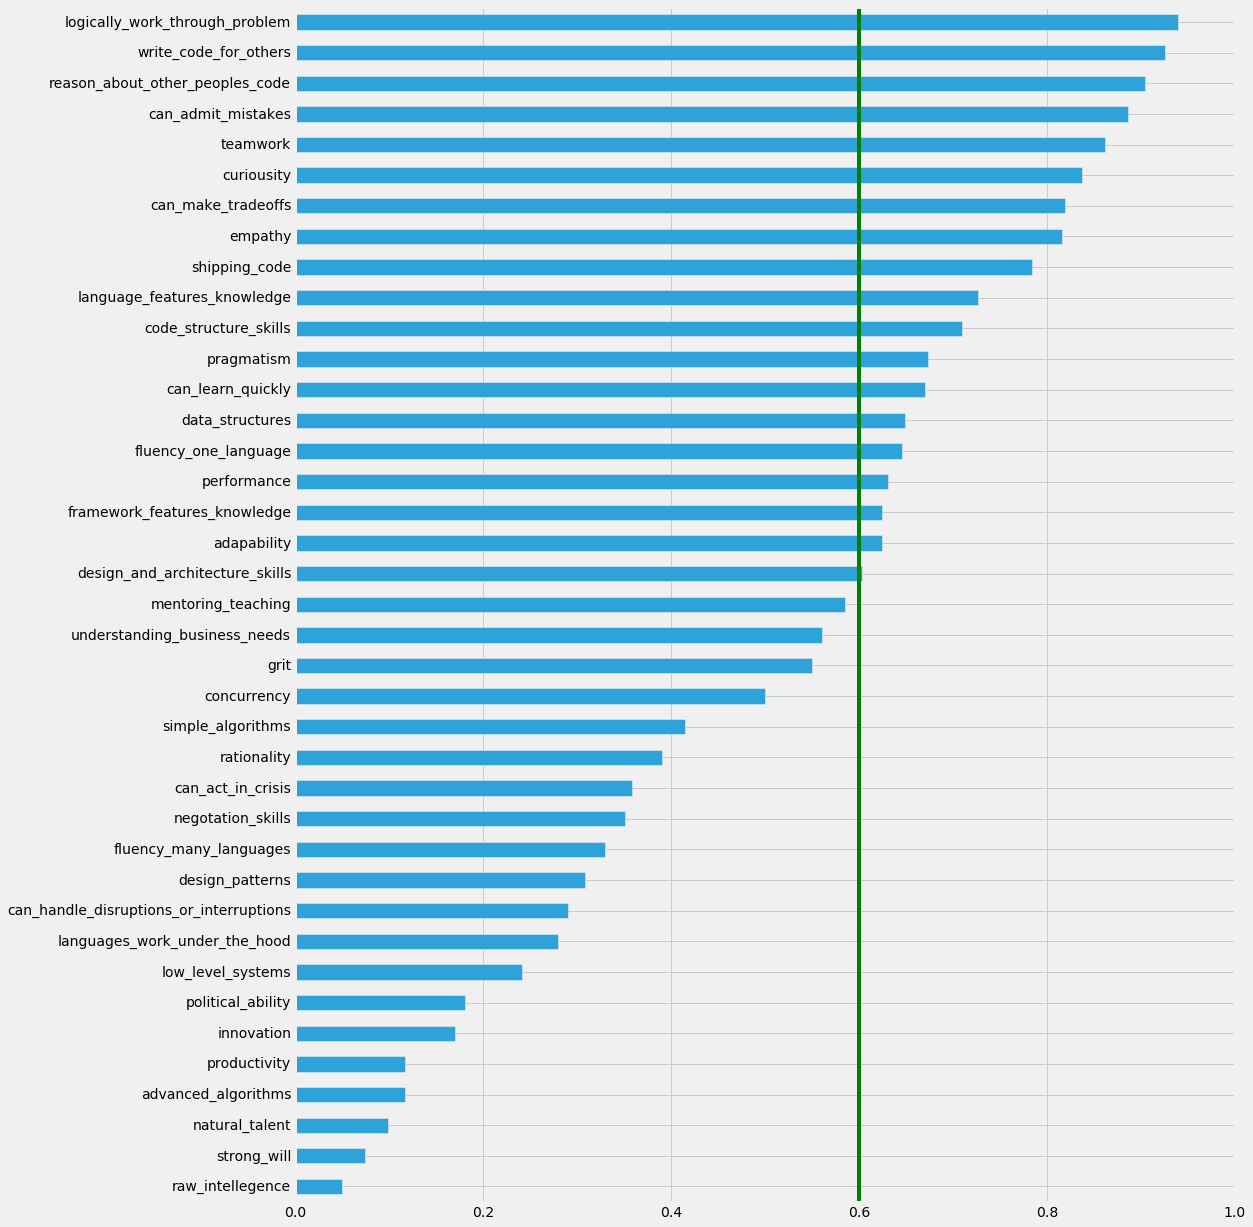

In [17]:
trait_plot3 = traits_data.stack()[DOES_NOT_HAVE_CS_DEGREE].sort_values(ascending=True).plot(kind='barh')
trait_plot3.axvline(0.6, color='g')


plt.show()

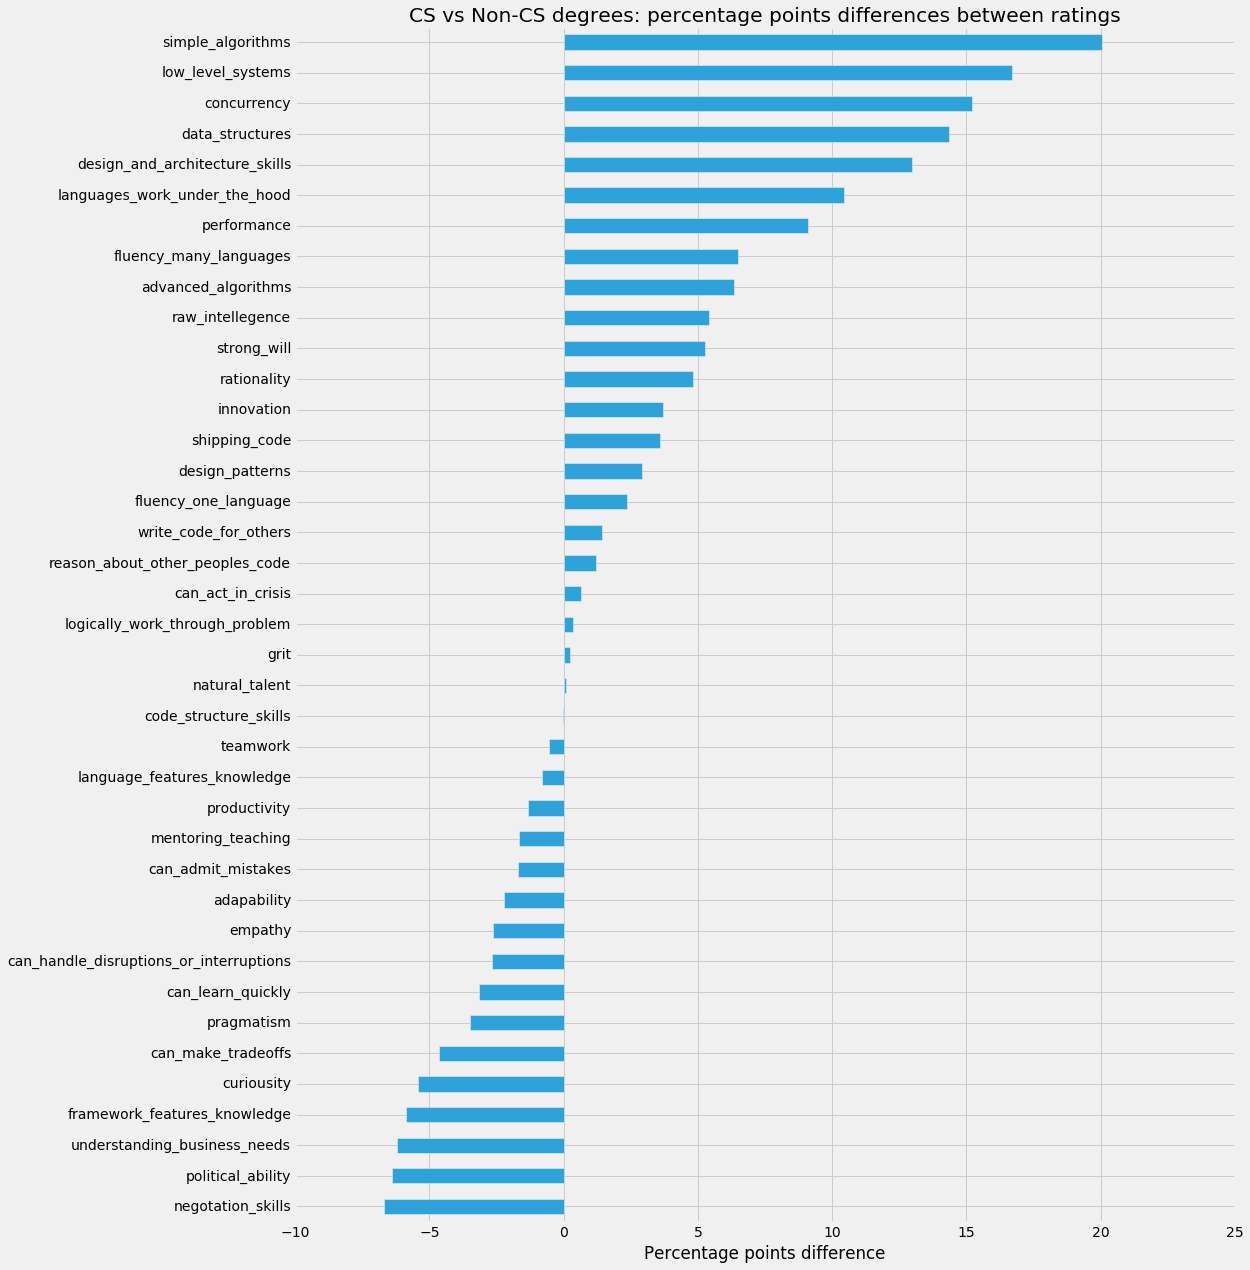

In [37]:
trait_plot = traits_difference.sort_values(ascending=True).plot(kind='barh')
trait_plot.set_title('CS vs Non-CS degrees: percentage points differences between ratings')
trait_plot.set_xlabel('Percentage points difference')

plt.show()

# Statistical significance

trying out t-test here

In [38]:
has_cs_deg_group = edu_traits_engineers_only_data[edu_traits_engineers_only_data['have_cs_degree'] == HAS_CS_DEGREE]
no_deg_group = edu_traits_engineers_only_data[edu_traits_engineers_only_data['have_cs_degree'] == DOES_NOT_HAVE_CS_DEGREE]

ttest_significance = []
for trait in eng_traits:
    result = stats.ttest_ind(has_cs_deg_group[trait], no_deg_group[trait])
    ttest_significance.append({'trait': trait, 'ttest_statistic': result.statistic, 'pvalue': result.pvalue})
    
ttest = pd.DataFrame(ttest_significance, columns=['trait', 'pvalue', 'ttest_statistic'])

The t-test is supposed to show how likely it is the two groups differ by chance, with the standard threshold being 5% (0.05). The correlation to this is 1 in 20 of these is statistically wrong.

In [41]:
ttest[ttest['pvalue'] <= 0.05].sort_values('pvalue')

,trait,pvalue,ttest_statistic
1,simple_algorithms,0.000001,4.925440
5,low_level_systems,0.000016,4.347556
0,data_structures,0.000102,3.912026
8,concurrency,0.000194,3.750589
9,design_and_architecture_skills,0.000875,3.345428
6,languages_work_under_the_hood,0.007559,2.680573
32,raw_intellegence,0.014846,2.443441
7,performance,0.018659,2.358922
24,political_ability,0.030479,-2.169134
2,advanced_algorithms,0.031854,2.151448


In [44]:
ttest.sort_values('pvalue')

,trait,pvalue,ttest_statistic
1,simple_algorithms,0.000001,4.925440
5,low_level_systems,0.000016,4.347556
0,data_structures,0.000102,3.912026
8,concurrency,0.000194,3.750589
9,design_and_architecture_skills,0.000875,3.345428
6,languages_work_under_the_hood,0.007559,2.680573
32,raw_intellegence,0.014846,2.443441
7,performance,0.018659,2.358922
24,political_ability,0.030479,-2.169134
2,advanced_algorithms,0.031854,2.151448
